In [1]:
# ==========================================================
# 0. Install & Import
# ==========================================================
# !pip -q install yfinance pandas numpy scikit-learn matplotlib tensorflow==2.* joblib

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import yfinance as yf
from datetime import datetime, timedelta

plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["axes.grid"] = True

2025-10-19 17:13:18.815887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/keitama/.local/share/pipx/venvs/ipykernel/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/keitama/.local/share/pipx/venvs/ipykernel/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid c

In [2]:
import ccxt
import pandas as pd
import time

binance = ccxt.binance()

symbol = "SOL/USDT"
timeframe = "1d"
since = binance.parse8601("2020-01-01T00:00:00Z")  # mulai dari 2020-01-01
limit = 1000  # max per request

all_ohlcv = []
while True:
    ohlcv = binance.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)
    if not ohlcv:
        break
    all_ohlcv += ohlcv
    since = ohlcv[-1][0] + 1  # lanjut dari candle terakhir
    time.sleep(binance.rateLimit / 1000)  # hindari ban IP

df = pd.DataFrame(all_ohlcv, columns=["timestamp","Open","High","Low","Close","Volume"])
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
df.set_index("timestamp", inplace=True)

print("Range data:", df.index.min(), "->", df.index.max())
print(df.tail())


Range data: 2020-08-11 00:00:00 -> 2025-10-19 00:00:00
              Open    High     Low   Close       Volume
timestamp                                              
2025-10-15  202.45  208.91  192.04  193.84  5369155.439
2025-10-16  193.84  198.42  182.03  184.85  5404640.663
2025-10-17  184.84  187.55  174.06  181.96  6102908.877
2025-10-18  181.97  188.26  181.75  187.56  2105841.095
2025-10-19  187.55  188.64  183.19  187.16   930327.575


In [3]:
# ==========================================================
# 2. Train-Test Split & Scaling
# ==========================================================
TRAIN_RATIO = 0.9
FEATURES = ["Open","High","Low","Close","Volume"]
TARGET   = "Close"
WINDOW   = 60
HORIZON  = 1

n = len(df)
n_train = int(n * TRAIN_RATIO)
df_train, df_test = df.iloc[:n_train], df.iloc[n_train:]

scaler = MinMaxScaler()
scaler.fit(df_train[FEATURES])

train_scaled = pd.DataFrame(scaler.transform(df_train[FEATURES]),
                            index=df_train.index, columns=FEATURES)
test_scaled  = pd.DataFrame(scaler.transform(df_test[FEATURES]),
                            index=df_test.index, columns=FEATURES)

os.makedirs("artifacts", exist_ok=True)
joblib.dump(scaler, "artifacts/scaler.pkl")


#Preprocessing dataset timeseries buat nanti di training
def make_xy(data_scaled, window=WINDOW, horizon=HORIZON, target_col=TARGET):
    X, y = [], []
    arr = data_scaled.values
    cols = list(data_scaled.columns)
    t_idx = cols.index(target_col)
    for i in range(len(arr) - window - horizon + 1):
        X.append(arr[i:i+window, :])
        y.append(arr[i+window+horizon-1, t_idx])
    return np.array(X), np.array(y)

X_train, y_train = make_xy(train_scaled)
X_test, y_test   = make_xy(test_scaled)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :",  y_test.shape)

X_train: (1646, 60, 5) y_train: (1646,)
X_test : (130, 60, 5) y_test : (130,)


In [4]:
# ==========================================================
# 3. Build Model CNN-BiLSTM
# ==========================================================
def build_cnn_bilstm(window=WINDOW, n_features=len(FEATURES), lr=1e-3):
    inp = layers.Input(shape=(window, n_features))
    x = layers.Conv1D(128, 3, padding='causal', activation='relu')(inp)  # Conv1D layer pertama
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, padding='causal', activation='relu')(x)    # Conv1D layer kedua
    x = layers.MaxPooling1D(2)(x)

    # BiLSTM layer: baca sekuens maju & mundur
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False, dropout=0.2), name="bilstm")(x)

    # Dense output layer (prediksi harga Close)
    out = layers.Dense(1, activation='linear')(x)

    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

MODEL_PATH = "artifacts/model_cnn_bilstm.h5"
model = build_cnn_bilstm()
model.summary()

2025-10-19 17:13:25.825861: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm (Bidirectional)          │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,753 (1.20 MB)

 Trainable params: 314,753 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Feature map CNN1: (1, 60, 128)


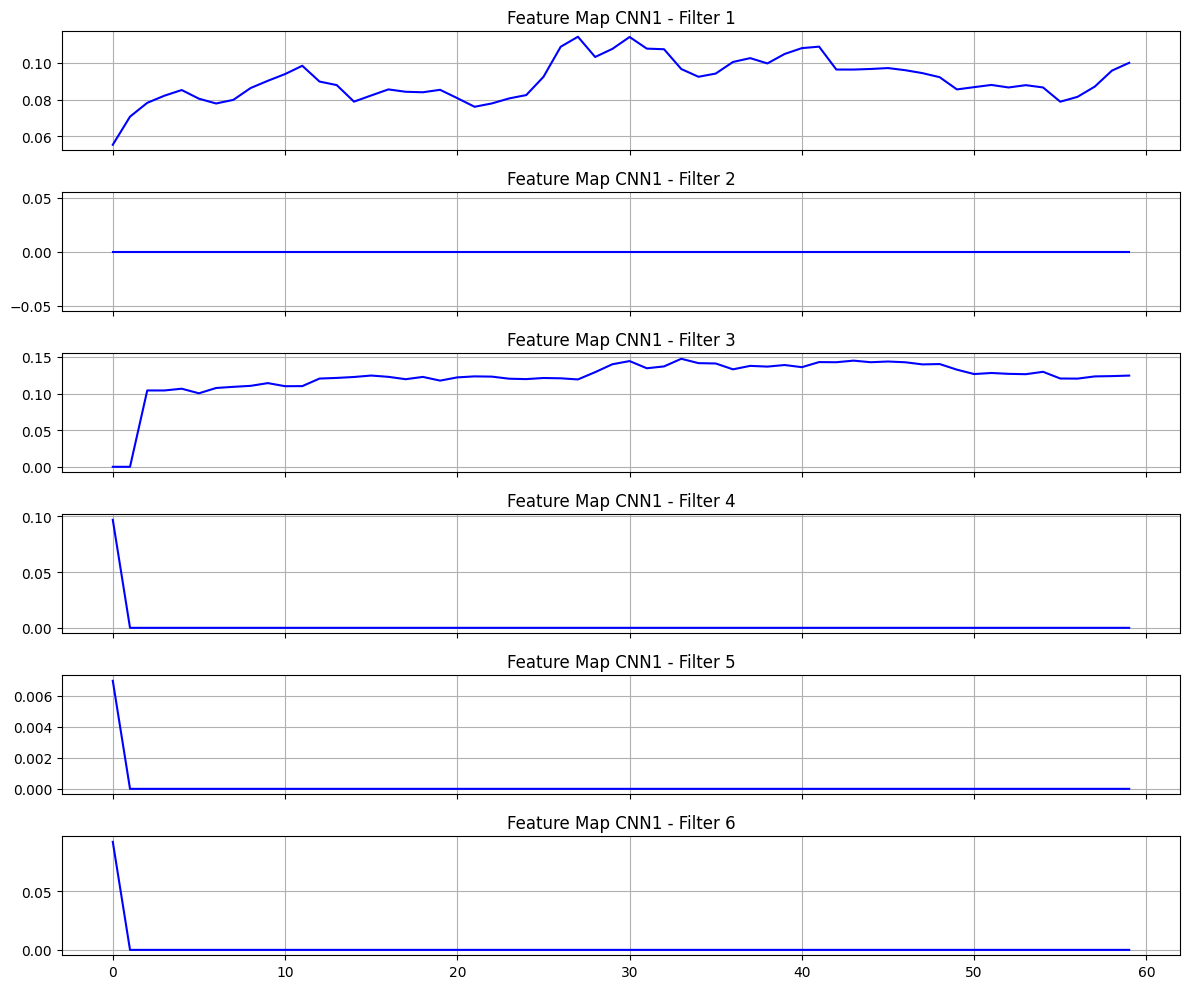

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Feature map CNN2: (1, 30, 128)


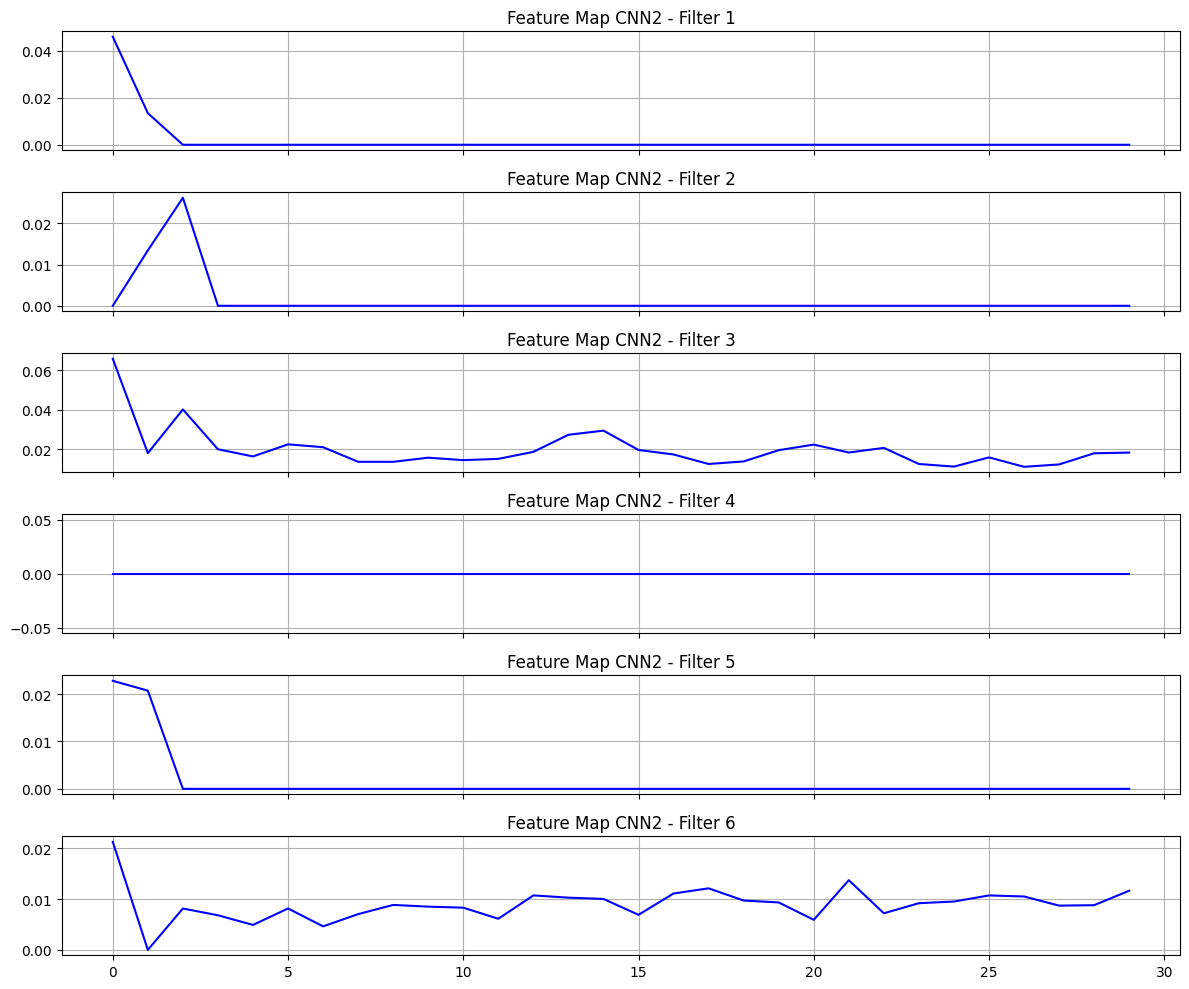

In [5]:
# ==========================================================
# Visualisasi Feature Map CNN
# ==========================================================
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Ambil satu sampel dari test set
sample = X_test[0:1]   # shape (1, WINDOW, features)

# --- CNN Pertama ---
layer_name_cnn1 = [l.name for l in model.layers if "conv1d" in l.name][0]
intermediate_cnn1 = Model(inputs=model.input, outputs=model.get_layer(layer_name_cnn1).output)
feature_maps_1 = intermediate_cnn1.predict(sample)

print("Feature map CNN1:", feature_maps_1.shape)

n_filters = min(6, feature_maps_1.shape[-1])
fig, axs = plt.subplots(n_filters, 1, figsize=(12, 10), sharex=True)
for i in range(n_filters):
    axs[i].plot(feature_maps_1[0, :, i], color="blue")
    axs[i].set_title(f"Feature Map CNN1 - Filter {i+1}")
plt.tight_layout(); plt.show()

# --- CNN Kedua ---
layer_name_cnn2 = [l.name for l in model.layers if "conv1d" in l.name][1]
intermediate_cnn2 = Model(inputs=model.input, outputs=model.get_layer(layer_name_cnn2).output)
feature_maps_2 = intermediate_cnn2.predict(sample)

print("Feature map CNN2:", feature_maps_2.shape)

n_filters = min(6, feature_maps_2.shape[-1])
fig, axs = plt.subplots(n_filters, 1, figsize=(12, 10), sharex=True)
for i in range(n_filters):
    axs[i].plot(feature_maps_2[0, :, i], color="blue")
    axs[i].set_title(f"Feature Map CNN2 - Filter {i+1}")
plt.tight_layout(); plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
BiLSTM output shape: (1, 256)


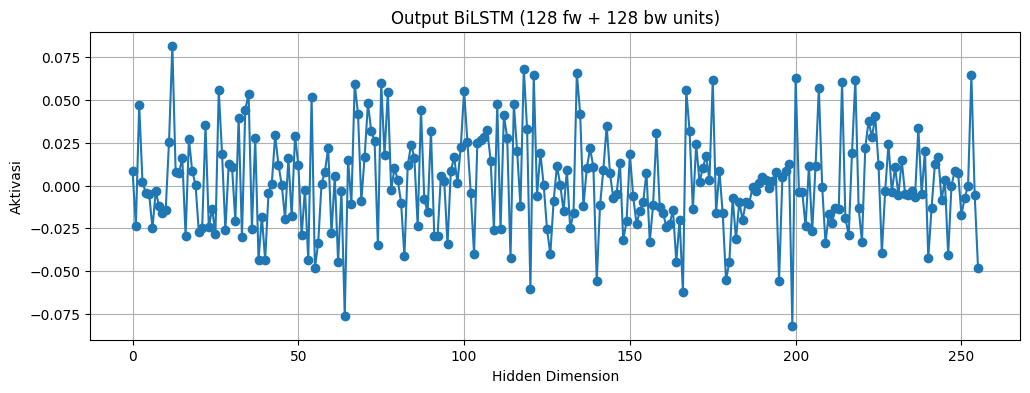

In [6]:
# ==========================================================
# 3. Visualisasi Output BiLSTM
# ==========================================================
layer_bilstm = model.get_layer("bilstm")
intermediate_bilstm = Model(inputs=model.input, outputs=layer_bilstm.output)
bilstm_output = intermediate_bilstm.predict(sample)

print("BiLSTM output shape:", bilstm_output.shape)

# Karena return_sequences=False → output 1 vektor (1, 256)
plt.figure(figsize=(12,4))
plt.plot(bilstm_output[0], marker='o')
plt.title("Output BiLSTM (128 fw + 128 bw units)")
plt.xlabel("Hidden Dimension")
plt.ylabel("Aktivasi")
plt.show()

>> Train new model (overwrite old one)


Epoch 1/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0563 - mean_absolute_error: 0.1571
Epoch 1: val_loss improved from None to 0.01871, saving model to artifacts/model_cnn_bilstm.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0264 - mean_absolute_error: 0.1068 - val_loss: 0.0187 - val_mean_absolute_error: 0.1167 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0087 - mean_absolute_error: 0.0648
Epoch 2: val_loss improved from 0.01871 to 0.00447, saving model to artifacts/model_cnn_bilstm.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0079 - mean_absolute_error: 0.0611 - val_loss: 0.0045 - val_mean_absolute_error: 0.0549 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0060 - mean_absolute_error: 0.0504
Epoch 3: val_loss improved from 0.00447 to 0.00413, saving model to artifacts/model_cnn_bilstm.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0054 - mean_absolute_error: 0.0483 - val_loss: 0.0041 - val_mean_absolute_error: 0.0534 - learning_rate: 0.0010
Epoch 4/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0042 - mean_absolute_error: 0.0419
Epoch 4: val_loss improved from 0.00413 to 0.00333, saving model to artifacts/model_cnn_bilstm.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0039 - mean_absolute_error: 0.0412 - val_loss: 0.0033 - val_mean_absolute_error: 0.0468 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0033 - mean_absolute_error: 0.0382
Epoch 5: val_loss improved from 0.00333 to 0.00322, saving model to artifacts/model_cnn_bilstm.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0031 - mean_absolute_error: 0.0370 - val_loss: 0.0032 - val_mean_absolute_error: 0.0452 - learning_rate: 0.0010
Epoch 6/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0035 - mean_absolute_error: 0.0390
Epoch 6: val_loss did not improve from 0.00322
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0034 - mean_absolute_error: 0.0378 - val_loss: 0.0135 - val_mean_absolute_error: 0.1039 - learning_rate: 0.0010
Epoch 7/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0037 - mean_absolute_error: 0.0392
Epoch 7: val_loss did not improve from 0.00322
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0035 - mean_absolute_error: 0.0380 - val_loss: 0.0043 - val_mean_absolute_error: 0.0535 - learning_rate: 0.0010
Epoch 8/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0026 - mean_absolute_error: 0.0331
Epoch 8: val_loss improved from 0.00322 to 0.00272, saving model to artifacts/model_cnn_bilstm.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0026 - mean_absolute_error: 0.0338 - val_loss: 0.0027 - val_mean_absolute_error: 0.0397 - learning_rate: 0.0010
Epoch 9/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0023 - mean_absolute_error: 0.0317
Epoch 9: val_loss did not improve from 0.00272
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0023 - mean_absolute_error: 0.0315 - val_loss: 0.0034 - val_mean_absolute_error: 0.0459 - learning_rate: 0.0010
Epoch 10/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0023 - mean_absolute_error: 0.0301
Epoch 10: val_loss improved from 0.00272 to 0.00271, saving model to artifacts/model_cnn_bilstm.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0021 - mean_absolute_error: 0.0294 - val_loss: 0.0027 - val_mean_absolute_error: 0.0401 - learning_rate: 0.0010
Epoch 11/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0018 - mean_absolute_error: 0.0277
Epoch 11: val_loss did not improve from 0.00271
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0020 - mean_absolute_error: 0.0290 - val_loss: 0.0051 - val_mean_absolute_error: 0.0588 - learning_rate: 0.0010
Epoch 12/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0031 - mean_absolute_error: 0.0355
Epoch 12: val_loss did not improve from 0.00271
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0024 - mean_absolute_error: 0.0324 - val_loss: 0.0031 - val_mean_absolute_error: 0.0434 - learning_rate: 0.0010
Epoch 13/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0019 - mean_absolute_error: 0.0275
Epoch 13: val_loss did not improve from 0.00271
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0019 - mean_absolute_error

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0015 - mean_absolute_error: 0.0256 - val_loss: 0.0023 - val_mean_absolute_error: 0.0366 - learning_rate: 0.0010
Epoch 15/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0017 - mean_absolute_error: 0.0262
Epoch 15: val_loss did not improve from 0.00230
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0018 - mean_absolute_error: 0.0281 - val_loss: 0.0040 - val_mean_absolute_error: 0.0511 - learning_rate: 0.0010
Epoch 16/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0017 - mean_absolute_error: 0.0263
Epoch 16: val_loss did not improve from 0.00230
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0017 - mean_absolute_error: 0.0271 - val_loss: 0.0025 - val_mean_absolute_error: 0.0392 - learning_rate: 0.0010
Epoch 17/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0020 - mean_absolute_error: 0.0293
Epoch 17: val_loss improved from 0.00230 to 0.00223, saving model to artifacts/model_cnn_bilstm.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0023 - mean_absolute_error: 0.0313 - val_loss: 0.0022 - val_mean_absolute_error: 0.0365 - learning_rate: 0.0010
Epoch 18/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0015 - mean_absolute_error: 0.0247
Epoch 18: val_loss improved from 0.00223 to 0.00200, saving model to artifacts/model_cnn_bilstm.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0016 - mean_absolute_error: 0.0259 - val_loss: 0.0020 - val_mean_absolute_error: 0.0349 - learning_rate: 0.0010
Epoch 19/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0015 - mean_absolute_error: 0.0250
Epoch 19: val_loss improved from 0.00200 to 0.00181, saving model to artifacts/model_cnn_bilstm.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0014 - mean_absolute_error: 0.0244 - val_loss: 0.0018 - val_mean_absolute_error: 0.0335 - learning_rate: 0.0010
Epoch 20/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0015 - mean_absolute_error: 0.0253
Epoch 20: val_loss did not improve from 0.00181
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0016 - mean_absolute_error: 0.0259 - val_loss: 0.0034 - val_mean_absolute_error: 0.0460 - learning_rate: 0.0010
Epoch 21/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0014 - mean_absolute_error: 0.0245
Epoch 21: val_loss did not improve from 0.00181
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0014 - mean_absolute_error: 0.0241 - val_loss: 0.0023 - val_mean_absolute_error: 0.0377 - learning_rate: 0.0010
Epoch 22/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0012 - mean_absolute_error: 0.0232
Epoch 22: val_loss did not improve from 0.00181
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0013 - mean_absolute_error

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0013 - mean_absolute_error: 0.0235 - val_loss: 0.0018 - val_mean_absolute_error: 0.0332 - learning_rate: 0.0010
Epoch 27/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0012 - mean_absolute_error: 0.0225
Epoch 27: val_loss did not improve from 0.00176
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012 - mean_absolute_error: 0.0220 - val_loss: 0.0018 - val_mean_absolute_error: 0.0336 - learning_rate: 5.0000e-04
Epoch 28/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0012 - mean_absolute_error: 0.0225
Epoch 28: val_loss did not improve from 0.00176
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0012 - mean_absolute_error: 0.0222 - val_loss: 0.0018 - val_mean_absolute_error: 0.0342 - learning_rate: 5.0000e-04
Epoch 29/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0011 - mean_absolute_error: 0.0215
Epoch 29: val_loss improved from 0.00176 to 0.00175, saving model to artifacts/model_cnn_bilstm.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0011 - mean_absolute_error: 0.0215 - val_loss: 0.0017 - val_mean_absolute_error: 0.0332 - learning_rate: 5.0000e-04
Epoch 30/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0012 - mean_absolute_error: 0.0227
Epoch 30: val_loss did not improve from 0.00175
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0012 - mean_absolute_error: 0.0222 - val_loss: 0.0021 - val_mean_absolute_error: 0.0366 - learning_rate: 5.0000e-04
Epoch 31/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0011 - mean_absolute_error: 0.0220
Epoch 31: val_loss did not improve from 0.00175
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0012 - mean_absolute_error: 0.0227 - val_loss: 0.0033 - val_mean_absolute_error: 0.0460 - learning_rate: 5.0000e-04
Epoch 32/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0012 - mean_absolute_error: 0.0222
Epoch 32: val_loss did not improve from 0.00175
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0011 - mean_ab

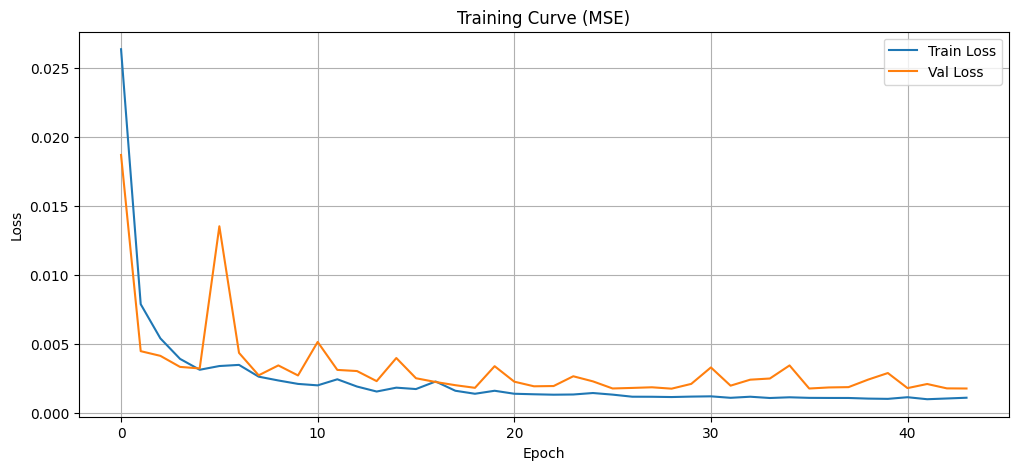

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm (Bidirectional)          │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,755 (1.20 MB)

 Trainable params: 314,753 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [7]:
# ==========================================================
# Training Model
# ==========================================================
print(">> Train new model (overwrite old one)")
ckp = callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1)
es  = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[es, rlr, ckp],
    verbose=1
)

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.title("Training Curve (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# load the best model (saved by checkpoint)
model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/stepWARNING:tensorflow:5 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7544d05f4b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step

=== FINAL EVALUATION ===
MAE  : 8.6448 USD
RMSE : 10.9027 USD
RMSE% : 5.82%
MAPE : 4.54%


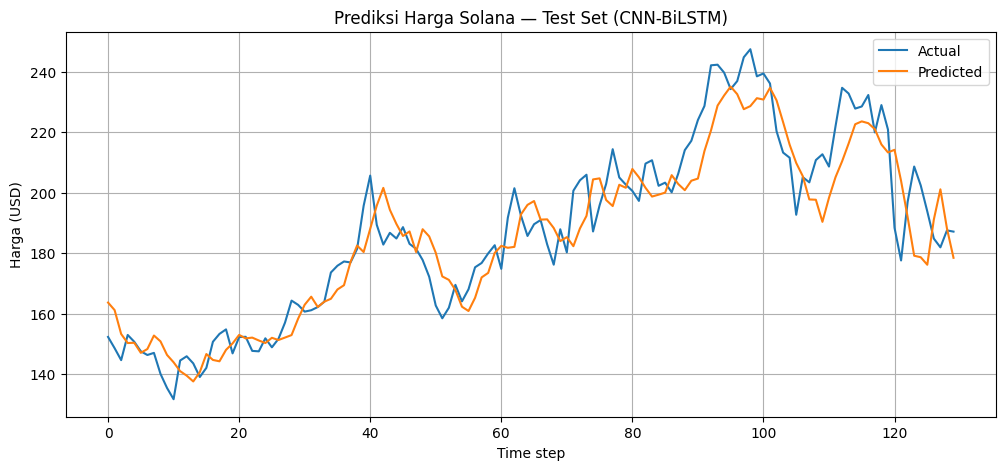

In [8]:
# ==========================================================
# 4. Evaluasi
# ==========================================================
def inverse_target(scaled_1d, scaler, feature_names=FEATURES, target_col=TARGET):
    scaled_1d = np.array(scaled_1d).reshape(-1)
    dummy = np.zeros((scaled_1d.shape[0], len(feature_names)))
    t_idx = feature_names.index(target_col)
    dummy[:, t_idx] = scaled_1d
    inv = scaler.inverse_transform(dummy)
    return inv[:, t_idx]

y_pred_scaled = model.predict(X_test).squeeze()
y_pred = inverse_target(y_pred_scaled, scaler)
y_true = inverse_target(y_test, scaler)

mae  = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
rmse_pct = (rmse / np.mean(y_true)) * 100
mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100

print("\n=== FINAL EVALUATION ===")
print(f"MAE  : {mae:.4f} USD")
print(f"RMSE : {rmse:.4f} USD")
print(f"RMSE% : {rmse_pct:.2f}%")
print(f"MAPE : {mape:.2f}%")

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Prediksi Harga Solana — Test Set (CNN-BiLSTM)")
plt.xlabel("Time step"); plt.ylabel("Harga (USD)")
plt.legend(); plt.show()

In [9]:
# ==========================================================
# 5. Realtime Prediction (Harian & Bulanan)
# ==========================================================
scaler_loaded = joblib.load("artifacts/scaler.pkl")
df_scaled_all = pd.DataFrame(scaler_loaded.transform(df[FEATURES]),
                             index=df.index, columns=FEATURES)

def predict_next(model, df_scaled_all, window=WINDOW):
    x = df_scaled_all.values[-window:]
    x = np.expand_dims(x, axis=0)
    y_hat_scaled = model.predict(x).squeeze()
    return inverse_target([y_hat_scaled], scaler_loaded, FEATURES, TARGET)[0]

def forecast_recursive(model, df_scaled_all, steps=30, window=WINDOW):
    buf = df_scaled_all.values.copy() # salin data terakhir
    preds_scaled = [] # simpan prediksi scaled
    t_idx = FEATURES.index(TARGET) # index kolom "Close"
    for _ in range(steps):
        x = np.expand_dims(buf[-window:], axis=0) # ambil window terakhir
        y_hat_scaled = model.predict(x).squeeze() # prediksi Close (scaled)
        preds_scaled.append(y_hat_scaled)

        # buat row baru, tapi nilai Close diganti prediksi
        new_row = buf[-1].copy()
        new_row[t_idx] = y_hat_scaled
        buf = np.vstack([buf, new_row])
    return inverse_target(preds_scaled, scaler_loaded, FEATURES, TARGET)

last_close = float(df["Close"].iloc[-1])
next_close_pred = predict_next(model, df_scaled_all)
pred_30d = forecast_recursive(model, df_scaled_all, steps=30)

print(f"\nLast Close : {last_close:.2f} USD")
print(f"Prediksi besok: {next_close_pred:.2f} USD")
print("Prediksi 30 hari ke depan (10 teratas):", np.round(pred_30d[:10], 2), "...")

# Bulanan (EOM dari forecast 30D)
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq="D")
future_df = pd.DataFrame({"Pred_Close": pred_30d}, index=future_index)
pred_monthly = future_df["Pred_Close"].resample("M").last()

print("\n=== Monthly Forecast (EOM) ===")
print(pred_monthly)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

/tmp/ipykernel_209298/3067737668.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_monthly = future_df["Pred_Close"].resample("M").last()


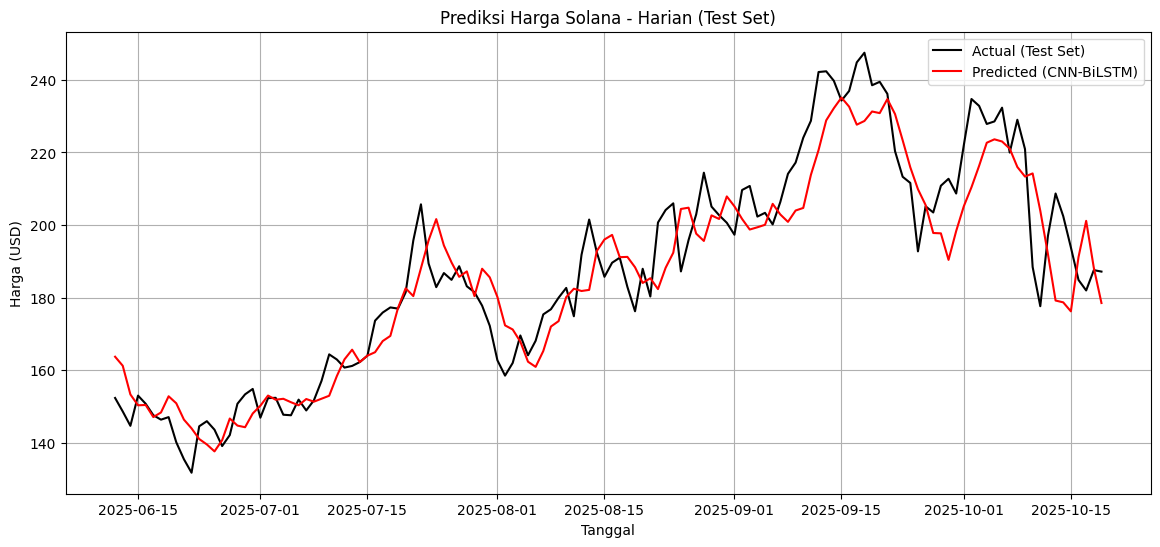

In [10]:
# ==========================================================
# 6. Visualization: Daily & Monthly Forecast
# ==========================================================

import matplotlib.dates as mdates

# Ambil index tanggal yang sesuai dengan y_test / y_pred
date_index = df_test.index[WINDOW:]

# --- Chart Prediksi Harian dengan Tanggal ---
plt.figure(figsize=(14,6))
plt.plot(date_index, y_true, label="Actual (Test Set)", color="black")
plt.plot(date_index, y_pred, label="Predicted (CNN-BiLSTM)", color="red")
plt.title("Prediksi Harga Solana - Harian (Test Set)")
plt.xlabel("Tanggal")
plt.ylabel("Harga (USD)")
plt.legend()
plt.grid(True)
plt.show()